In [139]:
conda install -c conda-forge xgboost=0.6a2

Retrieving notices: ...working... done
Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: failed

PackagesNotFoundError: The following packages are not available from current channels:

  - xgboost=0.6a2*

Current channels:

  - https://conda.anaconda.org/conda-forge
  - defaults

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.



Note: you may need to restart the kernel to use updated packages.


In [155]:
#import relevant libraries
import pandas as pd
pd.set_option('max_colwidth', 400)
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import nltk
from nltk.tokenize import RegexpTokenizer, sent_tokenize, word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk import FreqDist, pos_tag
nltk.download('punkt', quiet=True)
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
from nltk.sentiment.vader import SentimentIntensityAnalyzer


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay 
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andrewreusche/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [141]:
xgb_regressor = xgb.XGBRegressor()

In [2]:
df= pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding='ISO-8859-1')

In [3]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [5]:
#create a new df with just the data we want
raw_df= df[['tweet_text','is_there_an_emotion_directed_at_a_brand_or_product']]

In [6]:
raw_df.head()

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Positive emotion


In [7]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 2 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(2)
memory usage: 142.2+ KB


In [8]:
raw_df= raw_df.dropna()

In [9]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9092 entries, 0 to 9092
Data columns (total 2 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   is_there_an_emotion_directed_at_a_brand_or_product  9092 non-null   object
dtypes: object(2)
memory usage: 213.1+ KB


In [10]:
raw_df = raw_df.drop_duplicates(keep='first')
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9070 entries, 0 to 9092
Data columns (total 2 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9070 non-null   object
 1   is_there_an_emotion_directed_at_a_brand_or_product  9070 non-null   object
dtypes: object(2)
memory usage: 212.6+ KB


In [11]:
#lets rename the columns to more convienient nmames
raw_df = raw_df.rename(columns={'tweet_text': 'tweet', 
                                'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'})
raw_df.head()

,tweet,emotion
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Positive emotion


In [12]:
#lets check out the sentiment distribution to see if it is relatively ever or skewed
raw_df['emotion'].value_counts()

emotion
No emotion toward brand or product    5375
Positive emotion                      2970
Negative emotion                       569
I can't tell                           156
Name: count, dtype: int64

In [13]:
raw_df['emotion'].value_counts(normalize= True)

emotion
No emotion toward brand or product    0.592613
Positive emotion                      0.327453
Negative emotion                      0.062734
I can't tell                          0.017200
Name: proportion, dtype: float64

In [14]:
#get rid of all instances of 'couldn't tell'
rel_raw_df = raw_df[raw_df['emotion'] != "I can't tell"]
rel_raw_df['emotion'].value_counts()

emotion
No emotion toward brand or product    5375
Positive emotion                      2970
Negative emotion                       569
Name: count, dtype: int64

In [15]:
rel_raw_df['emotion'].value_counts(normalize= True)

emotion
No emotion toward brand or product    0.602984
Positive emotion                      0.333184
Negative emotion                      0.063832
Name: proportion, dtype: float64

In [16]:
#lower all the text strings
rel_raw_df["tweet"] = rel_raw_df["tweet"].str.lower()
rel_raw_df[:10]

/var/folders/p_/7g5qyc8d5zv5nfywm65yhpkc0000gn/T/ipykernel_25099/785506546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_raw_df["tweet"] = rel_raw_df["tweet"].str.lower()


,tweet,emotion
0,".@wesley83 i have a 3g iphone. after 3 hrs tweeting at #rise_austin, it was dead! i need to upgrade. plugin stations at #sxsw.",Negative emotion
1,"@jessedee know about @fludapp ? awesome ipad/iphone app that you'll likely appreciate for its design. also, they're giving free ts at #sxsw",Positive emotion
2,@swonderlin can not wait for #ipad 2 also. they should sale them down at #sxsw.,Positive emotion
3,@sxsw i hope this year's festival isn't as crashy as this year's iphone app. #sxsw,Negative emotion
4,"@sxtxstate great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech books/conferences) &amp; matt mullenweg (wordpress)",Positive emotion
5,@teachntech00 new ipad apps for #speechtherapy and communication are showcased at the #sxsw conference http://ht.ly/49n4m #iear #edchat #asd,No emotion toward brand or product
7,"#sxsw is just starting, #ctia is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan",Positive emotion
8,beautifully smart and simple idea rt @madebymany @thenextweb wrote about our #hollergram ipad app for #sxsw! http://bit.ly/ieavob,Positive emotion
9,counting down the days to #sxsw plus strong canadian dollar means stock up on apple gear,Positive emotion
10,excited to meet the @samsungmobileus at #sxsw so i can show them my sprint galaxy s still running android 2.1. #fail,Positive emotion


In [17]:
#make a new df column that associates sentiment with a number
sentiment_map = {'No emotion toward brand or product': 0,
    'Positive emotion': 1,
    'Negative emotion': 0}

rel_raw_df['sentiment'] = rel_raw_df['emotion'].map(sentiment_map)

rel_raw_df.head()

/var/folders/p_/7g5qyc8d5zv5nfywm65yhpkc0000gn/T/ipykernel_25099/1297960600.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_raw_df['sentiment'] = rel_raw_df['emotion'].map(sentiment_map)


,tweet,emotion,sentiment
0,".@wesley83 i have a 3g iphone. after 3 hrs tweeting at #rise_austin, it was dead! i need to upgrade. plugin stations at #sxsw.",Negative emotion,0
1,"@jessedee know about @fludapp ? awesome ipad/iphone app that you'll likely appreciate for its design. also, they're giving free ts at #sxsw",Positive emotion,1
2,@swonderlin can not wait for #ipad 2 also. they should sale them down at #sxsw.,Positive emotion,1
3,@sxsw i hope this year's festival isn't as crashy as this year's iphone app. #sxsw,Negative emotion,0
4,"@sxtxstate great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech books/conferences) &amp; matt mullenweg (wordpress)",Positive emotion,1


In [18]:
#v1
def strip_token(text):
    tweet = re.sub(r'http[s]?://\S+|www\.\S+', '', text)
    tweet = re.sub(r'@[\w]+', '', text)
    tweet = re.sub(r'#[\w]+', lambda x: x.group()[1:], text)
    tweet = re.sub(r'\d+', '', text)
    tweet = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

In [19]:
#v4
def strip_token(tweet):
    tweet = re.sub(r'http[s]?://\S+|www\.\S+', '', tweet)
    tweet = re.sub(r'[@#]\w+', lambda match: match.group(0)[1:], tweet)
    tweet = re.sub(r'&amp;', 'and', tweet)
    tweet = re.sub(r'/', ' ', tweet)
    tweet = re.sub(r'_', ' ', tweet)
    tweet = re.sub(r'\d+', '', tweet)
    tweet = re.sub(r'[^\w\s]', '', tweet)
    tokens = word_tokenize(tweet)
    return tokens

In [20]:
#grab a sample
samp1= rel_raw_df['tweet'][5]
samp1.split()

['@teachntech00',
 'new',
 'ipad',
 'apps',
 'for',
 '#speechtherapy',
 'and',
 'communication',
 'are',
 'showcased',
 'at',
 'the',
 '#sxsw',
 'conference',
 'http://ht.ly/49n4m',
 '#iear',
 '#edchat',
 '#asd']

In [21]:
strip_token(samp1)

['teachntech',
 'new',
 'ipad',
 'apps',
 'for',
 'speechtherapy',
 'and',
 'communication',
 'are',
 'showcased',
 'at',
 'the',
 'sxsw',
 'conference',
 'iear',
 'edchat',
 'asd']

In [22]:
samp2= rel_raw_df['tweet'][10]
samp2.split()

['excited',
 'to',
 'meet',
 'the',
 '@samsungmobileus',
 'at',
 '#sxsw',
 'so',
 'i',
 'can',
 'show',
 'them',
 'my',
 'sprint',
 'galaxy',
 's',
 'still',
 'running',
 'android',
 '2.1.',
 '#fail']

In [23]:
strip_token(samp2)

['excited',
 'to',
 'meet',
 'the',
 'samsungmobileus',
 'at',
 'sxsw',
 'so',
 'i',
 'can',
 'show',
 'them',
 'my',
 'sprint',
 'galaxy',
 's',
 'still',
 'running',
 'android',
 'fail']

In [24]:
samp3= rel_raw_df['tweet'][0]
samp3.split()

['.@wesley83',
 'i',
 'have',
 'a',
 '3g',
 'iphone.',
 'after',
 '3',
 'hrs',
 'tweeting',
 'at',
 '#rise_austin,',
 'it',
 'was',
 'dead!',
 'i',
 'need',
 'to',
 'upgrade.',
 'plugin',
 'stations',
 'at',
 '#sxsw.']

In [25]:
strip_token(samp3)

['wesley',
 'i',
 'have',
 'a',
 'g',
 'iphone',
 'after',
 'hrs',
 'tweeting',
 'at',
 'rise',
 'austin',
 'it',
 'was',
 'dead',
 'i',
 'need',
 'to',
 'upgrade',
 'plugin',
 'stations',
 'at',
 'sxsw']

In [26]:
samp4= rel_raw_df['tweet'][4]
samp4.split()

['@sxtxstate',
 'great',
 'stuff',
 'on',
 'fri',
 '#sxsw:',
 'marissa',
 'mayer',
 '(google),',
 'tim',
 "o'reilly",
 '(tech',
 'books/conferences)',
 '&amp;',
 'matt',
 'mullenweg',
 '(wordpress)']

In [27]:
samp4

"@sxtxstate great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech books/conferences) &amp; matt mullenweg (wordpress)"

In [28]:
strip_token(samp4)

['sxtxstate',
 'great',
 'stuff',
 'on',
 'fri',
 'sxsw',
 'marissa',
 'mayer',
 'google',
 'tim',
 'oreilly',
 'tech',
 'books',
 'conferences',
 'and',
 'matt',
 'mullenweg',
 'wordpress']

In [29]:
samp5= rel_raw_df['tweet'][22]
samp5.split()

['okay,',
 'this',
 'is',
 'really',
 'it:',
 'yay',
 'new',
 '@foursquare',
 'for',
 '#android',
 'app!!!!11',
 'kthxbai.',
 '#sxsw']

In [30]:
strip_token(samp5)

['okay',
 'this',
 'is',
 'really',
 'it',
 'yay',
 'new',
 'foursquare',
 'for',
 'android',
 'app',
 'kthxbai',
 'sxsw']

In [31]:
#apply it to the whole df
rel_raw_df['tweet_tokenized'] = rel_raw_df['tweet'].apply(strip_token)
rel_raw_df.head()

/var/folders/p_/7g5qyc8d5zv5nfywm65yhpkc0000gn/T/ipykernel_25099/288957299.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_raw_df['tweet_tokenized'] = rel_raw_df['tweet'].apply(strip_token)


,tweet,emotion,sentiment,tweet_tokenized
0,".@wesley83 i have a 3g iphone. after 3 hrs tweeting at #rise_austin, it was dead! i need to upgrade. plugin stations at #sxsw.",Negative emotion,0,"[wesley, i, have, a, g, iphone, after, hrs, tweeting, at, rise, austin, it, was, dead, i, need, to, upgrade, plugin, stations, at, sxsw]"
1,"@jessedee know about @fludapp ? awesome ipad/iphone app that you'll likely appreciate for its design. also, they're giving free ts at #sxsw",Positive emotion,1,"[jessedee, know, about, fludapp, awesome, ipad, iphone, app, that, youll, likely, appreciate, for, its, design, also, theyre, giving, free, ts, at, sxsw]"
2,@swonderlin can not wait for #ipad 2 also. they should sale them down at #sxsw.,Positive emotion,1,"[swonderlin, can, not, wait, for, ipad, also, they, should, sale, them, down, at, sxsw]"
3,@sxsw i hope this year's festival isn't as crashy as this year's iphone app. #sxsw,Negative emotion,0,"[sxsw, i, hope, this, years, festival, isnt, as, crashy, as, this, years, iphone, app, sxsw]"
4,"@sxtxstate great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech books/conferences) &amp; matt mullenweg (wordpress)",Positive emotion,1,"[sxtxstate, great, stuff, on, fri, sxsw, marissa, mayer, google, tim, oreilly, tech, books, conferences, and, matt, mullenweg, wordpress]"


In [32]:
#remove the stop words
stopwords_list= stopwords.words('english')
stopwords_list = [word for word in stopwords_list if word != 'not']

def remove_stopwords(token_list):
    list_stripped= [x for x in token_list if x not in stopwords_list]
    return list_stripped

rel_raw_df["tweet_tokenized_ns"] = rel_raw_df["tweet_tokenized"].apply(remove_stopwords)

print('previous tokens')
print(rel_raw_df["tweet_tokenized"].head())
print()
print('ns tokens')
print(rel_raw_df["tweet_tokenized_ns"].head())

previous tokens
0                     [wesley, i, have, a, g, iphone, after, hrs, tweeting, at, rise, austin, it, was, dead, i, need, to, upgrade, plugin, stations, at, sxsw]
1    [jessedee, know, about, fludapp, awesome, ipad, iphone, app, that, youll, likely, appreciate, for, its, design, also, theyre, giving, free, ts, at, sxsw]
2                                                                      [swonderlin, can, not, wait, for, ipad, also, they, should, sale, them, down, at, sxsw]
3                                                                 [sxsw, i, hope, this, years, festival, isnt, as, crashy, as, this, years, iphone, app, sxsw]
4                    [sxtxstate, great, stuff, on, fri, sxsw, marissa, mayer, google, tim, oreilly, tech, books, conferences, and, matt, mullenweg, wordpress]
Name: tweet_tokenized, dtype: object

ns tokens
0                                       [wesley, g, iphone, hrs, tweeting, rise, austin, dead, need, upgrade, plugin, stations, sxsw]
1      

/var/folders/p_/7g5qyc8d5zv5nfywm65yhpkc0000gn/T/ipykernel_25099/396995990.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_raw_df["tweet_tokenized_ns"] = rel_raw_df["tweet_tokenized"].apply(remove_stopwords)


In [33]:
#lemmetize the tokens
lemmatizer = WordNetLemmatizer()

def lem_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

rel_raw_df["tweet_lem"] = rel_raw_df["tweet_tokenized_ns"].apply(lem_tokens)

print('ns tokens')
print(rel_raw_df["tweet_tokenized_ns"].head())
print()
print('lem tokens')
print(rel_raw_df["tweet_lem"].head())

ns tokens
0                                       [wesley, g, iphone, hrs, tweeting, rise, austin, dead, need, upgrade, plugin, stations, sxsw]
1      [jessedee, know, fludapp, awesome, ipad, iphone, app, youll, likely, appreciate, design, also, theyre, giving, free, ts, sxsw]
2                                                                                     [swonderlin, not, wait, ipad, also, sale, sxsw]
3                                                               [sxsw, hope, years, festival, isnt, crashy, years, iphone, app, sxsw]
4    [sxtxstate, great, stuff, fri, sxsw, marissa, mayer, google, tim, oreilly, tech, books, conferences, matt, mullenweg, wordpress]
Name: tweet_tokenized_ns, dtype: object

lem tokens
0                                       [wesley, g, iphone, hr, tweeting, rise, austin, dead, need, upgrade, plugin, station, sxsw]
1     [jessedee, know, fludapp, awesome, ipad, iphone, app, youll, likely, appreciate, design, also, theyre, giving, free, t, sxsw]
2   

/var/folders/p_/7g5qyc8d5zv5nfywm65yhpkc0000gn/T/ipykernel_25099/2582844597.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_raw_df["tweet_lem"] = rel_raw_df["tweet_tokenized_ns"].apply(lem_tokens)


In [34]:
#check to see if anthing was changed, it was 
rel_raw_df["tweet_lem"]==rel_raw_df["tweet_tokenized_ns"]

0       False
1       False
2        True
3       False
4       False
        ...  
9088     True
9089    False
9090    False
9091    False
9092    False
Length: 8914, dtype: bool

In [35]:
#train val test split

In [36]:
rel_raw_df['sentiment'].value_counts(normalize= True)

sentiment
0    0.666816
1    0.333184
Name: proportion, dtype: float64

In [37]:
rel_raw_df.head()

,tweet,emotion,sentiment,tweet_tokenized,tweet_tokenized_ns,tweet_lem
0,".@wesley83 i have a 3g iphone. after 3 hrs tweeting at #rise_austin, it was dead! i need to upgrade. plugin stations at #sxsw.",Negative emotion,0,"[wesley, i, have, a, g, iphone, after, hrs, tweeting, at, rise, austin, it, was, dead, i, need, to, upgrade, plugin, stations, at, sxsw]","[wesley, g, iphone, hrs, tweeting, rise, austin, dead, need, upgrade, plugin, stations, sxsw]","[wesley, g, iphone, hr, tweeting, rise, austin, dead, need, upgrade, plugin, station, sxsw]"
1,"@jessedee know about @fludapp ? awesome ipad/iphone app that you'll likely appreciate for its design. also, they're giving free ts at #sxsw",Positive emotion,1,"[jessedee, know, about, fludapp, awesome, ipad, iphone, app, that, youll, likely, appreciate, for, its, design, also, theyre, giving, free, ts, at, sxsw]","[jessedee, know, fludapp, awesome, ipad, iphone, app, youll, likely, appreciate, design, also, theyre, giving, free, ts, sxsw]","[jessedee, know, fludapp, awesome, ipad, iphone, app, youll, likely, appreciate, design, also, theyre, giving, free, t, sxsw]"
2,@swonderlin can not wait for #ipad 2 also. they should sale them down at #sxsw.,Positive emotion,1,"[swonderlin, can, not, wait, for, ipad, also, they, should, sale, them, down, at, sxsw]","[swonderlin, not, wait, ipad, also, sale, sxsw]","[swonderlin, not, wait, ipad, also, sale, sxsw]"
3,@sxsw i hope this year's festival isn't as crashy as this year's iphone app. #sxsw,Negative emotion,0,"[sxsw, i, hope, this, years, festival, isnt, as, crashy, as, this, years, iphone, app, sxsw]","[sxsw, hope, years, festival, isnt, crashy, years, iphone, app, sxsw]","[sxsw, hope, year, festival, isnt, crashy, year, iphone, app, sxsw]"
4,"@sxtxstate great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech books/conferences) &amp; matt mullenweg (wordpress)",Positive emotion,1,"[sxtxstate, great, stuff, on, fri, sxsw, marissa, mayer, google, tim, oreilly, tech, books, conferences, and, matt, mullenweg, wordpress]","[sxtxstate, great, stuff, fri, sxsw, marissa, mayer, google, tim, oreilly, tech, books, conferences, matt, mullenweg, wordpress]","[sxtxstate, great, stuff, fri, sxsw, marissa, mayer, google, tim, oreilly, tech, book, conference, matt, mullenweg, wordpress]"


In [38]:
#set x and y 
X= rel_raw_df['tweet_lem']
y= rel_raw_df['sentiment']

In [39]:
#i want 80% training data, 10% validation data, and 10% test data 

#Train split (remain is the remaining data)
X_train, X_remain, y_train, y_remain= train_test_split(X, y, 
                                                   test_size= 0.2,  
                                                   random_state= 24)

#Val test split 
X_val, X_test, y_val, y_test= train_test_split(X_remain, y_remain,
                                               test_size= 0.5, 
                                               random_state= 24)

In [40]:
X_train.head()

7595                                                                      [google, circle, happening, lost, sxsw]
2916                                     [apple, opening, popup, shop, downtown, austin, sxsw, link, rt, mention]
4121                                                      [cool, apple, open, temporary, store, sxsw, link, sxsw]
8303    [cant, wait, see, internet, implode, austin, friday, everyone, stop, normal, activity, order, ipad, sxsw]
8165                                         [lifter, link, google, league, extraordinary, hckers, mention, sxsw]
Name: tweet_lem, dtype: object

/var/folders/p_/7g5qyc8d5zv5nfywm65yhpkc0000gn/T/ipykernel_25099/2455087314.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(words, rotation=45, ha='right')


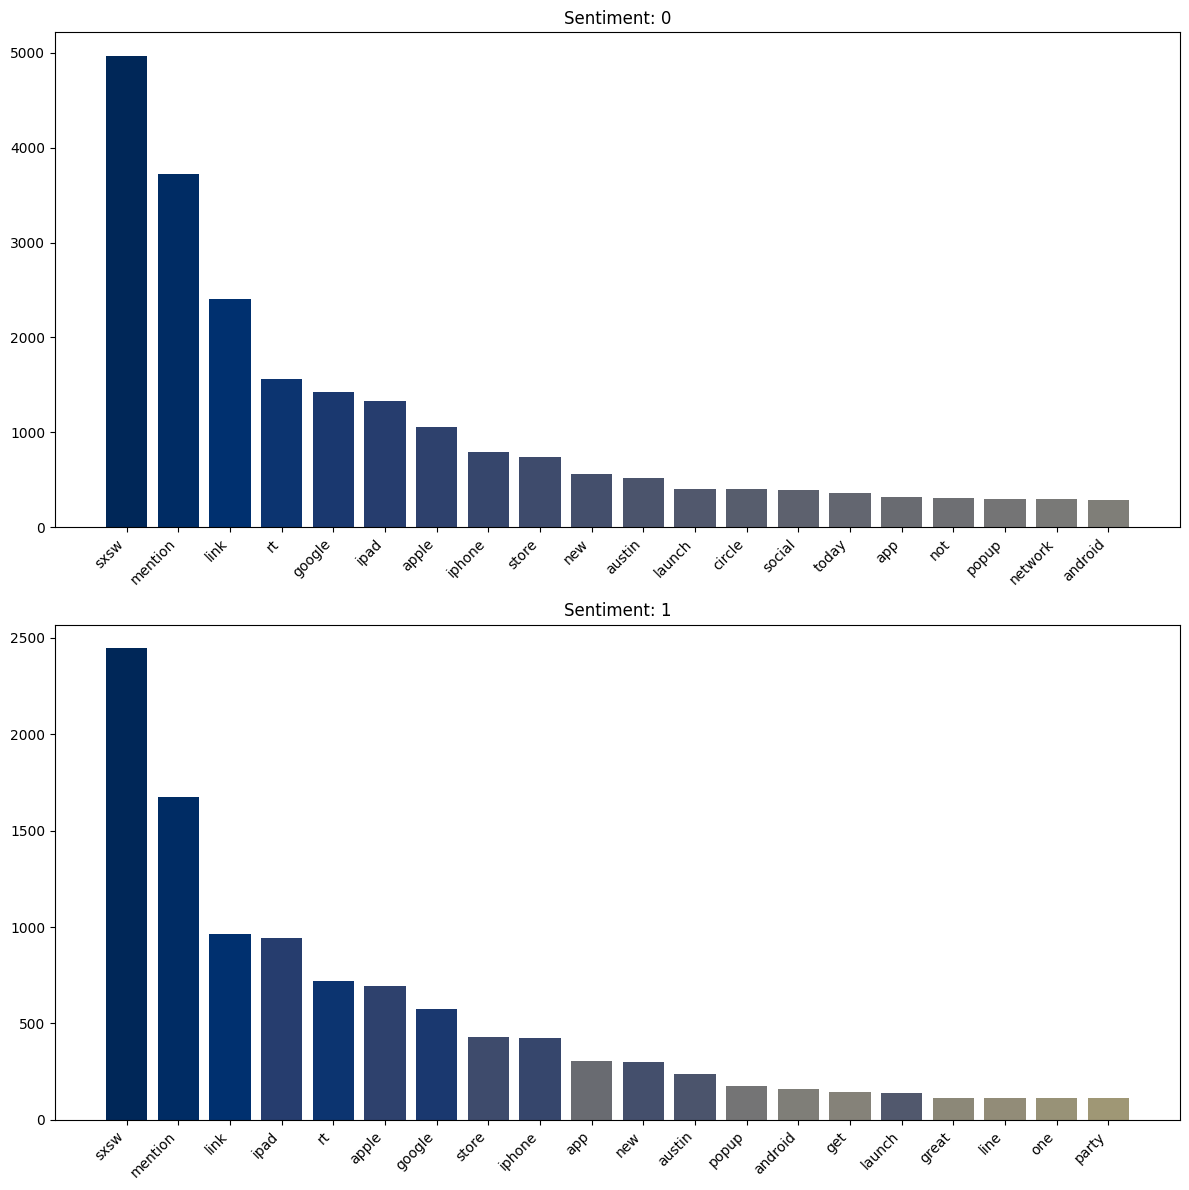

In [41]:
#check out the word distrobutions in X_train for each target class

from collections import Counter

color_palette = sns.color_palette('cividis', n_colors=38)

fig, axes = plt.subplots(nrows=2, figsize=(12, 12)) 

plotted_words_and_colors = {}

sentiment_classes = y_train.unique() 
for i, sentiment_class in enumerate(sentiment_classes):
    sentiment_data = X_train[y_train == sentiment_class]
    all_words_in_sentiment = [word for tokens in sentiment_data for word in tokens]
    top_10 = Counter(all_words_in_sentiment).most_common(20)
    
    colors = []
    
    for word, _ in top_10:
        if word not in plotted_words_and_colors:
            new_color = color_palette.pop(0)
            plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
    
    ax = axes[i]
    words, counts = zip(*top_10)
    ax.bar(words, counts, color=colors)
    ax.set_title(f'Sentiment: {sentiment_class}') 
    ax.set_xticklabels(words, rotation=45, ha='right')

fig.tight_layout() 
plt.show()

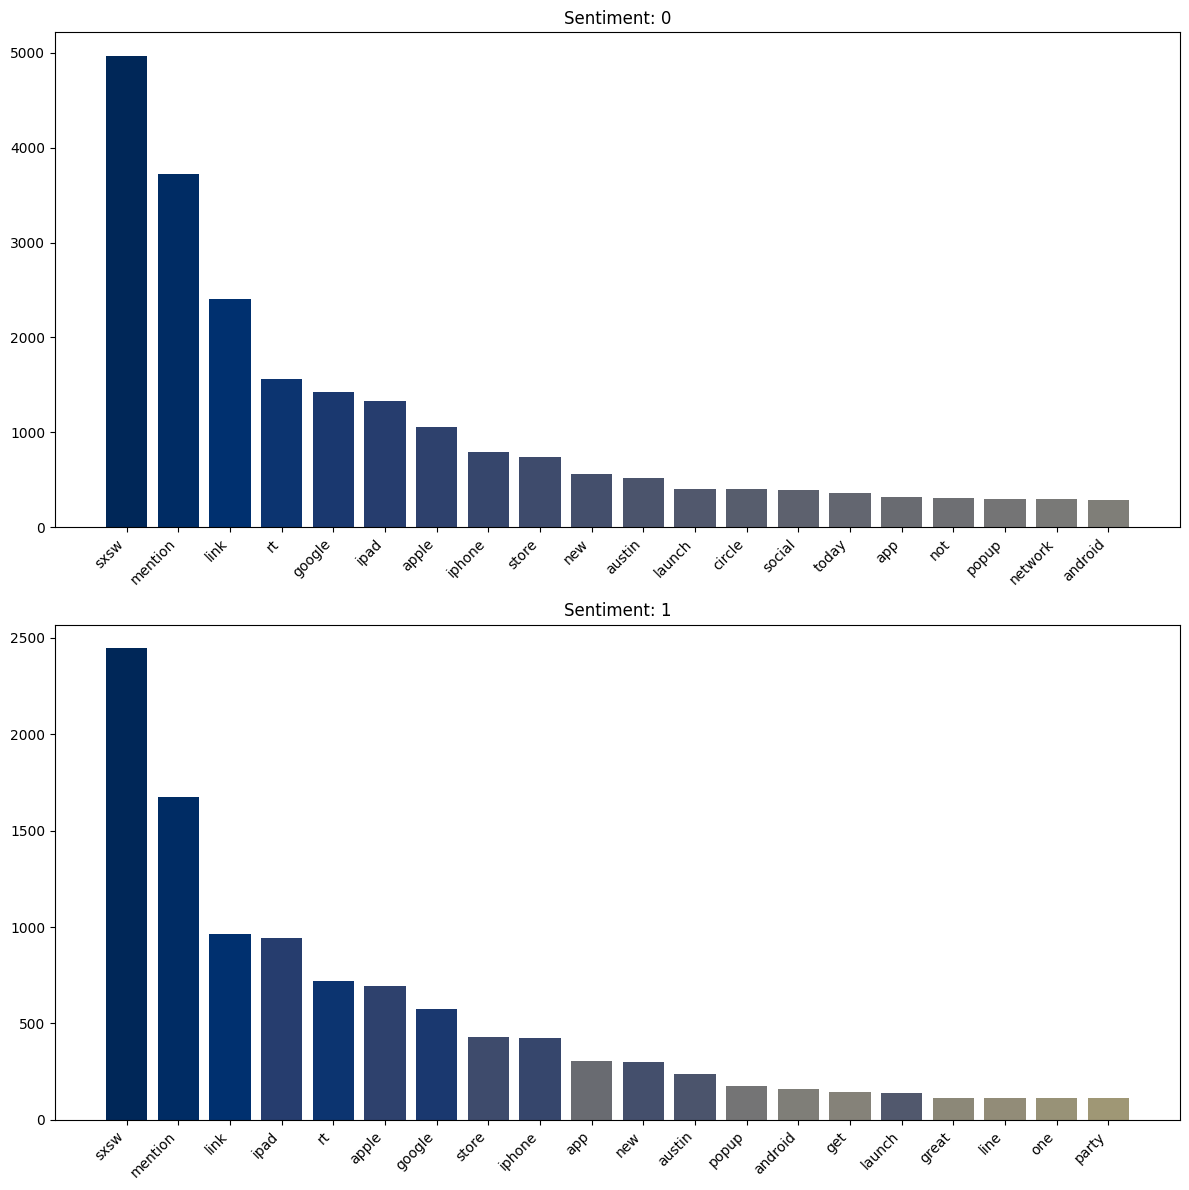

In [42]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

color_palette = sns.color_palette('cividis', n_colors=38)

# Create subplots for each sentiment class
fig, axes = plt.subplots(nrows=2, figsize=(12, 12)) 

plotted_words_and_colors = {}

sentiment_classes = y_train.unique() 
for i, sentiment_class in enumerate(sentiment_classes):
    sentiment_data = X_train[y_train == sentiment_class]
    all_words_in_sentiment = [word for tokens in sentiment_data for word in tokens]
    
    # Get top 20 most frequent words
    top_10 = Counter(all_words_in_sentiment).most_common(20)
    
    # Set colors for each word
    colors = []
    for word, _ in top_10:
        if word not in plotted_words_and_colors:
            new_color = color_palette.pop(0)
            plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
    
    # Plot word frequencies
    ax = axes[i]
    words, counts = zip(*top_10)
    ax.bar(words, counts, color=colors)
    ax.set_title(f'Sentiment: {sentiment_class}') 
    ax.set_xticks(range(len(words)))  # Ensure words are properly spaced
    ax.set_xticklabels(words, rotation=45, ha='right')

fig.tight_layout() 
plt.show()


In [45]:
y_train.value_counts(normalize= True)

sentiment
0    0.667508
1    0.332492
Name: proportion, dtype: float64

In [47]:
#clearly skewed, random undesampling could help fix this
X_train

7595                                                                                                 [google, circle, happening, lost, sxsw]
2916                                                                [apple, opening, popup, shop, downtown, austin, sxsw, link, rt, mention]
4121                                                                                 [cool, apple, open, temporary, store, sxsw, link, sxsw]
8303                               [cant, wait, see, internet, implode, austin, friday, everyone, stop, normal, activity, order, ipad, sxsw]
8165                                                                    [lifter, link, google, league, extraordinary, hckers, mention, sxsw]
                                                                        ...                                                                 
6630    [rt, mention, rt, mention, yes, updated, iphone, app, song, info, mention, stream, others, also, live, video, streaming, sxsw, link]
5353         

In [62]:
# Join token lists into strings
X_train_str = X_train.apply(' '.join)
X_val_str = X_val.apply(' '.join)
X_test_str = X_test.apply(' '.join)

In [63]:
X_train_str

7595                                                                                   google circle happening lost sxsw
2916                                                       apple opening popup shop downtown austin sxsw link rt mention
4121                                                                      cool apple open temporary store sxsw link sxsw
8303                          cant wait see internet implode austin friday everyone stop normal activity order ipad sxsw
8165                                                         lifter link google league extraordinary hckers mention sxsw
                                                              ...                                                       
6630    rt mention rt mention yes updated iphone app song info mention stream others also live video streaming sxsw link
5353                               rt mention million people go google every month get doctor information vitalscom sxsw
3544                            

In [120]:
#make a pipeline
pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=24))])

In [121]:
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [1000, 1500, 2000, 2500],
    'tfidf__ngram_range': [(1, 2), (1, 3), (1, 5)]}

In [122]:
#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=1,
    verbose=0)

In [123]:
grid_search1.fit(X_train_str, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf',
                                        LogisticRegression(random_state=24))]),
             n_jobs=1,
             param_grid={'tfidf__max_features': [1000, 1500, 2000, 2500],
                         'tfidf__ngram_range': [(1, 2), (1, 3), (1, 5)]},
             scoring='accuracy')

In [69]:
len(X_train_str)

7131

In [89]:
print("Best parameters found: ", grid_search1.best_params_)
print("Best cross-validation score: ", grid_search1.best_score_)

Best parameters found:  {'tfidf__max_features': 2000, 'tfidf__ngram_range': (1, 2)}
Best cross-validation score:  0.7237418804443653


In [124]:
# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'tfidf__max_features': 2500, 'tfidf__ngram_range': (1, 2)}
Best Train Cross-Validation Score: 0.7253
Validation Set Accuracy: 0.7576


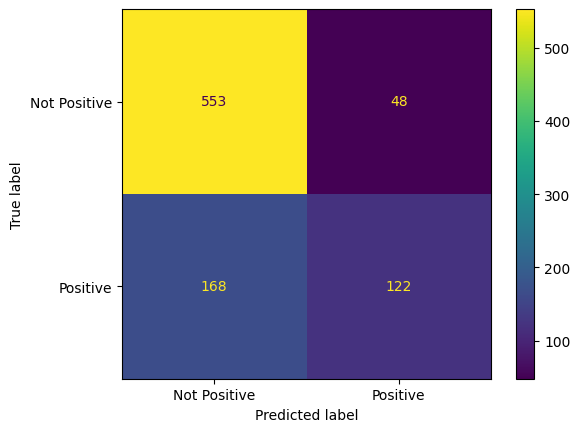

In [125]:
cm = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(cm, display_labels=['Not Positive', 'Positive']).plot()
plt.show()

In [126]:
# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'tfidf__max_features': 2500, 'tfidf__ngram_range': (1, 2)}
Best Train Cross-Validation Score: 0.7253
Validation Set Accuracy: 0.7576


In [92]:
#this is our baseline model

In [98]:
#make another pipleine but with random undersampling
pipeline1_2 = Pipeline([('undersample', RandomUnderSampler(random_state=24)),
    ('tfidf', TfidfVectorizer()),  # TF-IDF Vectorizer
    ('clf', LogisticRegression(random_state=24))])

param_grid1_2 = {'tfidf__max_features': [1000, 1500, 2000, 2500],
    'tfidf__ngram_range': [(1, 2), (1, 3), (1, 5)]}

grid_search1_2 = GridSearchCV(pipeline1_2,
    param_grid1_2,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1)

grid_search1_2.fit(X_train_str, y_train)

best_model1_2 = grid_search1_2.best_estimator_

y_val_pred1_2 = best_model1_2.predict(X_val_str)
val_accuracy1_2 = accuracy_score(y_val, y_val_pred1_2)

best_params1_2 = grid_search1_2.best_params_


print(f"Best Hyperparameters (with undersampling): {best_params1_2}")
print(f"Best Train Cross-Validation Score (with undersampling): {grid_search1_2.best_score_:.4f}")
print(f"Validation Set Accuracy (with undersampling): {val_accuracy1_2:.4f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits


ValueError: 
All the 60 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/my_py_3_8_5_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/my_py_3_8_5_env/lib/python3.8/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/envs/my_py_3_8_5_env/lib/python3.8/site-packages/sklearn/pipeline.py", line 423, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/anaconda3/envs/my_py_3_8_5_env/lib/python3.8/site-packages/sklearn/pipeline.py", line 357, in _fit
    self._validate_steps()
  File "/opt/anaconda3/envs/my_py_3_8_5_env/lib/python3.8/site-packages/sklearn/pipeline.py", line 241, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'RandomUnderSampler(random_state=24)' (type <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'>) doesn't


In [112]:
# Import necessary libraries
from imblearn.pipeline import Pipeline as ImbPipeline  # Importing ImbPipeline from imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler  # Importing RandomUnderSampler from imbalanced-learn
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

# Create another pipeline with random undersampling
pipeline1_2 = ImbPipeline([
    ('tfidf', TfidfVectorizer()),  # TF-IDF Vectorizer
    ('undersample', RandomUnderSampler(random_state=24)),  # Random undersampling step
    ('clf', LogisticRegression(random_state=24))  # Logistic Regression classifier
])

# Define the parameter grid for the grid search
param_grid1_2 = {
    'tfidf__max_features': [1000, 1500, 2000, 2500],
    'tfidf__ngram_range': [(1, 2), (1, 3), (1, 5)]
}

# Perform grid search to find the best parameters with undersampling
grid_search1_2 = GridSearchCV(
    pipeline1_2,  # Use the correct pipeline here
    param_grid1_2,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search with undersampling to the training data
grid_search1_2.fit(X_train_str, y_train)

# Get the best model from the grid search
best_model1_2 = grid_search1_2.best_estimator_

# Evaluate the performance on the validation set
y_val_pred1_2 = best_model1_2.predict(X_val_str)
val_accuracy1_2 = accuracy_score(y_val, y_val_pred1_2)

# Get the best hyperparameters for the undersampling pipeline
best_params1_2 = grid_search1_2.best_params_

# Output the results
print(f"Best Hyperparameters (with undersampling): {best_params1_2}")
print(f"Best Train Cross-Validation Score (with undersampling): {grid_search1_2.best_score_:.8f}")
print(f"Validation Set Accuracy (with undersampling): {val_accuracy1_2:.8f}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Hyperparameters (with undersampling): {'tfidf__max_features': 2500, 'tfidf__ngram_range': (1, 2)}
Best Train Cross-Validation Score (with undersampling): 0.67325660
Validation Set Accuracy (with undersampling): 0.69360269


In [105]:
#this seems to decrease the accuracy of the model 

In [111]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Create a pipeline where undersampling and SMOTE are applied after TF-IDF vectorization
pipeline_combined = ImbPipeline([
    ('tfidf', TfidfVectorizer()),  # TF-IDF Vectorizer (text to feature matrix)
    ('undersample', RandomUnderSampler(random_state=24)),  # Random Under-sampling
    ('smote', SMOTE(random_state=24)),  # SMOTE for oversampling the minority class
    ('clf', LogisticRegression(random_state=24))  # Logistic Regression Classifier
])

# Define the parameter grid for GridSearchCV
param_grid_combined = {
    'tfidf__max_features': [1000, 1500, 2000, 2500],
    'tfidf__ngram_range': [(1, 2), (1, 3), (1, 5)],
    'clf__C': [0.1, 1, 10]  # Hyperparameter for Logistic Regression (regularization strength)
}

# Create the GridSearchCV object
grid_search_combined = GridSearchCV(
    pipeline_combined,
    param_grid_combined,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search on the training data
grid_search_combined.fit(X_train_str, y_train)

# Get the best model
best_model_combined = grid_search_combined.best_estimator_

# Predict on the validation set
y_val_pred_combined = best_model_combined.predict(X_val_str)

# Calculate accuracy on the validation set
val_accuracy_combined = accuracy_score(y_val, y_val_pred_combined)

# Get the best parameters from the grid search
best_params_combined = grid_search_combined.best_params_

# Output the results
print(f"Best Hyperparameters (with undersampling + SMOTE): {best_params_combined}")
print(f"Best Train Cross-Validation Score (with undersampling + SMOTE): {grid_search_combined.best_score_:.8f}")
print(f"Validation Set Accuracy (with undersampling + SMOTE): {val_accuracy_combined:.8f}")


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Hyperparameters (with undersampling + SMOTE): {'clf__C': 1, 'tfidf__max_features': 2500, 'tfidf__ngram_range': (1, 2)}
Best Train Cross-Validation Score (with undersampling + SMOTE): 0.67325660
Validation Set Accuracy (with undersampling + SMOTE): 0.69360269


In [113]:
#smoting doesn't seem to do anything

/opt/anaconda3/envs/my_py_3_8_5_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/my_py_3_8_5_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

## method 2

In [127]:
# Add imblearn imports
from imblearn.pipeline import Pipeline as ImbPipeline  # Use this instead of sklearn Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Join token lists into strings (unchanged)
X_train_str = X_train.apply(' '.join)
X_val_str = X_val.apply(' '.join)
X_test_str = X_test.apply(' '.join)

# Check initial distribution
print("Original Training Sentiment Distribution:")
print(y_train.value_counts(normalize=True))

# --- Pipeline 1: Random Undersampling ---
pipeline_under = ImbPipeline([
    ('tfidf', TfidfVectorizer()),
    ('undersample', RandomUnderSampler(random_state=24)),
    ('clf', LogisticRegression(random_state=24))
])

param_grid_under = {
    'tfidf__max_features': [1000, 1500, 2000, 2500],
    'tfidf__ngram_range': [(1, 2), (1, 3), (1, 5)]
}

grid_search_under = GridSearchCV(
    pipeline_under,
    param_grid_under,
    cv=5,
    scoring='accuracy',
    n_jobs=1,
    verbose=1
)

# Fit with undersampling
grid_search_under.fit(X_train_str, y_train)

# Results
best_train_cv_score_under = grid_search_under.best_score_
best_model_under = grid_search_under.best_estimator_
y_val_pred_under = best_model_under.predict(X_val_str)
val_accuracy_under = accuracy_score(y_val, y_val_pred_under)
best_params_under = grid_search_under.best_params_

print("\nRandom Undersampling Results:")
print(f"Best Hyperparameters: {best_params_under}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score_under:.4f}")
print(f"Validation Set Accuracy: {val_accuracy_under:.4f}")

Original Training Sentiment Distribution:
sentiment
0    0.667508
1    0.332492
Name: proportion, dtype: float64
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Random Undersampling Results:
Best Hyperparameters: {'tfidf__max_features': 2500, 'tfidf__ngram_range': (1, 2)}
Best Train Cross-Validation Score: 0.6733
Validation Set Accuracy: 0.6936


In [128]:
#clearly jusrt undersampling hurts here

In [129]:
#lets try smote and random under

In [130]:
# --- Pipeline 2: SMOTE + Random Undersampling ---
pipeline_smote_under = ImbPipeline([
    ('tfidf', TfidfVectorizer()),
    ('smote', SMOTE(random_state=24)),
    ('undersample', RandomUnderSampler(random_state=24)),
    ('clf', LogisticRegression(random_state=24))
])

param_grid_smote_under = {
    'tfidf__max_features': [1000, 1500, 2000, 2500],
    'tfidf__ngram_range': [(1, 2), (1, 3), (1, 5)]
}

grid_search_smote_under = GridSearchCV(
    pipeline_smote_under,
    param_grid_smote_under,
    cv=5,
    scoring='accuracy',
    n_jobs=1,
    verbose=1
)

# Fit with SMOTE + undersampling
grid_search_smote_under.fit(X_train_str, y_train)

# Results
best_train_cv_score_smote_under = grid_search_smote_under.best_score_
best_model_smote_under = grid_search_smote_under.best_estimator_
y_val_pred_smote_under = best_model_smote_under.predict(X_val_str)
val_accuracy_smote_under = accuracy_score(y_val, y_val_pred_smote_under)
best_params_smote_under = grid_search_smote_under.best_params_

print("\nSMOTE + Random Undersampling Results:")
print(f"Best Hyperparameters: {best_params_smote_under}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score_smote_under:.4f}")
print(f"Validation Set Accuracy: {val_accuracy_smote_under:.4f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits

SMOTE + Random Undersampling Results:
Best Hyperparameters: {'tfidf__max_features': 2500, 'tfidf__ngram_range': (1, 2)}
Best Train Cross-Validation Score: 0.6929
Validation Set Accuracy: 0.7048


In [131]:
# smote and random under is better than random under but not better than just doing it with the current as is class imblance

In [132]:
#try running this base against other classifiers 

In [147]:
possible_classifiers= [LogisticRegression(), 
              MultinomialNB(), 
              LinearSVC(), 
              DecisionTreeClassifier(), 
              RandomForestClassifier(),
              KNeighborsClassifier(),
              GradientBoostingClassifier(),
              xgb_regressor, 
              neural_network]

NameError: name 'neural_network' is not defined

# version 1

In [149]:
pip install keras==2.12.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 2.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 2.13.1
    Uninstalling keras-2.13.1:
      Successfully uninstalled keras-2.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-macos 2.13.0 requires keras<2.14,>=2.13.1, but you have keras 2.12.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [151]:
pip install tensorflow==2.8


ERROR: Could not find a version that satisfies the requirement tensorflow==2.8 (from versions: 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1)
ERROR: No matching distribution found for tensorflow==2.8
Note: you may need to restart the kernel to use updated packages.


In [152]:
from sklearn.neural_network import MLPClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define a function to create a neural network model
def create_nn_model():
    model = Sequential()
    model.add(Dense(128, input_dim=2500, activation='relu'))  # Input layer (use TF-IDF features)
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))  # Hidden layer
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))  # Output layer (binary classification)
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Convert it to a KerasClassifier to integrate with GridSearchCV
nn_model = KerasClassifier(build_fn=create_nn_model, epochs=10, batch_size=32, verbose=0)


ImportError: cannot import name 'dtensor_api' from 'keras.dtensor' (/opt/anaconda3/envs/my_py_3_8_5_env/lib/python3.8/site-packages/keras/dtensor/__init__.py)

# version 2


In [153]:
# XGboost first

In [157]:
# Base param grid for TF-IDF
base_param_grid = {
    'tfidf__max_features': [1000, 1500, 2000, 2500],
    'tfidf__ngram_range': [(1, 2), (1, 3), (1, 5)]
}

# XGBoost Pipeline
pipeline_xgb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', XGBClassifier(random_state=24, use_label_encoder=False, eval_metric='logloss'))
])

# Parameter grid for XGBoost
param_grid_xgb = {
    **base_param_grid,
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [3, 5],
    'clf__learning_rate': [0.1, 0.3],  # Default is 0.3
    'clf__scale_pos_weight': [2]}

# Run grid search
grid_search_xgb = GridSearchCV(
    pipeline_xgb,
    param_grid_xgb,
    cv=5,
    scoring='accuracy',
    n_jobs=1,
    verbose=1
)

# Fit on training data
grid_search_xgb.fit(X_train_str, y_train)

# Results
best_train_cv_score_xgb = grid_search_xgb.best_score_
best_model_xgb = grid_search_xgb.best_estimator_
y_val_pred_xgb = best_model_xgb.predict(X_val_str)
val_accuracy_xgb = accuracy_score(y_val, y_val_pred_xgb)
best_params_xgb = grid_search_xgb.best_params_

print("\nXGBoost Results:")
print(f"Best Hyperparameters: {best_params_xgb}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score_xgb:.4f}")
print(f"Validation Set Accuracy: {val_accuracy_xgb:.4f}")

# Compare to base
print("\nComparison:")
print(f"Logistic Regression (Base) Validation Accuracy: 0.7576")
print(f"XGBoost Validation Accuracy: {val_accuracy_xgb:.4f}")

Fitting 5 folds for each of 96 candidates, totalling 480 fits


/opt/anaconda3/envs/my_py_3_8_5_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:20:54] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/my_py_3_8_5_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:20:54] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/my_py_3_8_5_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:20:54] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/e


XGBoost Results:
Best Hyperparameters: {'clf__learning_rate': 0.3, 'clf__max_depth': 5, 'clf__n_estimators': 200, 'clf__scale_pos_weight': 2, 'tfidf__max_features': 2500, 'tfidf__ngram_range': (1, 3)}
Best Train Cross-Validation Score: 0.6968
Validation Set Accuracy: 0.7306

Comparison:
Logistic Regression (Base) Validation Accuracy: 0.7576
XGBoost Validation Accuracy: 0.7306


In [158]:
#xg boost didn't help, lets go a wide grid search for other classifiers

In [159]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# Join token lists into strings (unchanged)
X_train_str = X_train.apply(' '.join)
X_val_str = X_val.apply(' '.join)
X_test_str = X_test.apply(' '.join)

# Base param grid for TF-IDF
base_param_grid = {
    'tfidf__max_features': [1000, 1500, 2000, 2500],
    'tfidf__ngram_range': [(1, 2), (1, 3), (1, 5)]
}

# Function to run grid search and print results
def run_grid_search(pipeline, param_grid, name):
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=1,
        verbose=1
    )
    grid_search.fit(X_train_str, y_train)
    best_train_cv_score = grid_search.best_score_
    best_model = grid_search.best_estimator_
    y_val_pred = best_model.predict(X_val_str)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    best_params = grid_search.best_params_
    print(f"\n{name} Results:")
    print(f"Best Hyperparameters: {best_params}")
    print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
    print(f"Validation Set Accuracy: {val_accuracy:.4f}")
    return best_model, val_accuracy

# 1. Multinomial Naive Bayes
pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])
param_grid_nb = base_param_grid
best_model_nb, val_accuracy_nb = run_grid_search(pipeline_nb, param_grid_nb, "Multinomial Naive Bayes")

# 2. Linear SVC
pipeline_svc = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC(random_state=24))
])
param_grid_svc = {
    **base_param_grid,
    'clf__C': [0.1, 1, 10]  # Regularization strength
}
best_model_svc, val_accuracy_svc = run_grid_search(pipeline_svc, param_grid_svc, "Linear SVC")

# 3. Random Forest
pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(random_state=24))
])
param_grid_rf = {
    **base_param_grid,
    'clf__n_estimators': [100, 200],  # Number of trees
    'clf__max_depth': [10, 20]       # Limit depth
}
best_model_rf, val_accuracy_rf = run_grid_search(pipeline_rf, param_grid_rf, "Random Forest")

# 4. Gradient Boosting
pipeline_gb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', GradientBoostingClassifier(random_state=24))
])
param_grid_gb = {
    **base_param_grid,
    'clf__n_estimators': [100, 200],  # Number of trees
    'clf__max_depth': [3, 5]         # Shallow trees
}
best_model_gb, val_accuracy_gb = run_grid_search(pipeline_gb, param_grid_gb, "Gradient Boosting")

# 5. MLPClassifier
pipeline_mlp = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MLPClassifier(random_state=24, max_iter=300))
])
param_grid_mlp = {
    **base_param_grid,
    'clf__hidden_layer_sizes': [(50,), (100,)],  # Small nets
    'clf__alpha': [0.0001, 0.001]               # Regularization
}
best_model_mlp, val_accuracy_mlp = run_grid_search(pipeline_mlp, param_grid_mlp, "MLPClassifier")

# Compare all results
print("\nSummary of Validation Accuracies:")
print(f"Logistic Regression (Base): 0.7576")
print(f"Multinomial Naive Bayes: {val_accuracy_nb:.4f}")
print(f"Linear SVC: {val_accuracy_svc:.4f}")
print(f"Random Forest: {val_accuracy_rf:.4f}")
print(f"Gradient Boosting: {val_accuracy_gb:.4f}")
print(f"MLPClassifier: {val_accuracy_mlp:.4f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Multinomial Naive Bayes Results:
Best Hyperparameters: {'tfidf__max_features': 1500, 'tfidf__ngram_range': (1, 2)}
Best Train Cross-Validation Score: 0.7136
Validation Set Accuracy: 0.7318
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/opt/anaconda3/envs/my_py_3_8_5_env/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/envs/my_py_3_8_5_env/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/envs/my_py_3_8_5_env/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/envs/my_py_3_8_5_env/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the wa


Linear SVC Results:
Best Hyperparameters: {'clf__C': 0.1, 'tfidf__max_features': 2500, 'tfidf__ngram_range': (1, 2)}
Best Train Cross-Validation Score: 0.7253
Validation Set Accuracy: 0.7609
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Random Forest Results:
Best Hyperparameters: {'clf__max_depth': 20, 'clf__n_estimators': 100, 'tfidf__max_features': 1000, 'tfidf__ngram_range': (1, 3)}
Best Train Cross-Validation Score: 0.7002
Validation Set Accuracy: 0.7104
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Gradient Boosting Results:
Best Hyperparameters: {'clf__max_depth': 5, 'clf__n_estimators': 200, 'tfidf__max_features': 1000, 'tfidf__ngram_range': (1, 2)}
Best Train Cross-Validation Score: 0.7215
Validation Set Accuracy: 0.7553
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/opt/anaconda3/envs/my_py_3_8_5_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/my_py_3_8_5_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/my_py_3_8_5_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/my_py_3_8_5_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  war


MLPClassifier Results:
Best Hyperparameters: {'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (100,), 'tfidf__max_features': 1000, 'tfidf__ngram_range': (1, 2)}
Best Train Cross-Validation Score: 0.7057
Validation Set Accuracy: 0.7452

Summary of Validation Accuracies:
Logistic Regression (Base): 0.7576
Multinomial Naive Bayes: 0.7318
Linear SVC: 0.7609
Random Forest: 0.7104
Gradient Boosting: 0.7553
MLPClassifier: 0.7452


In [161]:
"""
Multinomial Naive Bayes Results:
Best Hyperparameters: {'tfidf__max_features': 1500, 'tfidf__ngram_range': (1, 2)}
Best Train Cross-Validation Score: 0.7136
Validation Set Accuracy: 0.7318
Fitting 5 folds for each of 36 candidates, totalling 180 fits 

Linear SVC Results:
Best Hyperparameters: {'clf__C': 0.1, 'tfidf__max_features': 2500, 'tfidf__ngram_range': (1, 2)}
Best Train Cross-Validation Score: 0.7253
Validation Set Accuracy: 0.7609
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Random Forest Results:
Best Hyperparameters: {'clf__max_depth': 20, 'clf__n_estimators': 100, 'tfidf__max_features': 1000, 'tfidf__ngram_range': (1, 3)}
Best Train Cross-Validation Score: 0.7002
Validation Set Accuracy: 0.7104
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Gradient Boosting Results:
Best Hyperparameters: {'clf__max_depth': 5, 'clf__n_estimators': 200, 'tfidf__max_features': 1000, 'tfidf__ngram_range': (1, 2)}
Best Train Cross-Validation Score: 0.7215
Validation Set Accuracy: 0.7553
Fitting 5 folds for each of 48 candidates, totalling 240 fits

MLPClassifier Results:
Best Hyperparameters: {'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (100,), 'tfidf__max_features': 1000, 'tfidf__ngram_range': (1, 2)}
Best Train Cross-Validation Score: 0.7057
Validation Set Accuracy: 0.7452


Summary of Validation Accuracies:
Logistic Regression (Base): 0.7576
Multinomial Naive Bayes: 0.7318
Linear SVC: 0.7609
Random Forest: 0.7104
Gradient Boosting: 0.7553
MLPClassifier: 0.7452
"""

"\nMultinomial Naive Bayes Results:\nBest Hyperparameters: {'tfidf__max_features': 1500, 'tfidf__ngram_range': (1, 2)}\nBest Train Cross-Validation Score: 0.7136\nValidation Set Accuracy: 0.7318\nFitting 5 folds for each of 36 candidates, totalling 180 fits \n\nLinear SVC Results:\nBest Hyperparameters: {'clf__C': 0.1, 'tfidf__max_features': 2500, 'tfidf__ngram_range': (1, 2)}\nBest Train Cross-Validation Score: 0.7253\nValidation Set Accuracy: 0.7609\nFitting 5 folds for each of 48 candidates, totalling 240 fits\n\nRandom Forest Results:\nBest Hyperparameters: {'clf__max_depth': 20, 'clf__n_estimators': 100, 'tfidf__max_features': 1000, 'tfidf__ngram_range': (1, 3)}\nBest Train Cross-Validation Score: 0.7002\nValidation Set Accuracy: 0.7104\nFitting 5 folds for each of 48 candidates, totalling 240 fits\n\nGradient Boosting Results:\nBest Hyperparameters: {'clf__max_depth': 5, 'clf__n_estimators': 200, 'tfidf__max_features': 1000, 'tfidf__ngram_range': (1, 2)}\nBest Train Cross-Validat

In [164]:
#lets see how a deeper neural network would compare to this

In [165]:
# Join token lists into strings (unchanged)
X_train_str = X_train.apply(' '.join)
X_val_str = X_val.apply(' '.join)
X_test_str = X_test.apply(' '.join)

# Pipeline
pipeline_mlp = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MLPClassifier(random_state=24, max_iter=500))  # More iterations for convergence
])

# Parameter grid
param_grid_mlp = {
    'tfidf__max_features': [1500, 2500],           # Focus on top performers from LR/SVC
    'tfidf__ngram_range': [(1, 2), (1, 3)],        # Bigrams and trigrams worked well
    'clf__hidden_layer_sizes': [(50,), (100,), (50, 50)],  # Single and double layers
    'clf__alpha': [0.0001, 0.001],                 # Regularization
    'clf__learning_rate_init': [0.001, 0.01]       # Learning rate tweaks
}

# Grid search
grid_search_mlp = GridSearchCV(
    pipeline_mlp,
    param_grid_mlp,
    cv=5,
    scoring='accuracy',
    n_jobs=1,
    verbose=1
)

# Fit
grid_search_mlp.fit(X_train_str, y_train)

# Results
best_train_cv_score_mlp = grid_search_mlp.best_score_
best_model_mlp = grid_search_mlp.best_estimator_
y_val_pred_mlp = best_model_mlp.predict(X_val_str)
val_accuracy_mlp = accuracy_score(y_val, y_val_pred_mlp)
best_params_mlp = grid_search_mlp.best_params_

print("\nMLPClassifier Results:")
print(f"Best Hyperparameters: {best_params_mlp}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score_mlp:.4f}")
print(f"Validation Set Accuracy: {val_accuracy_mlp:.4f}")

# Compare
print("\nComparison:")
print(f"Logistic Regression (Base) Validation Accuracy: 0.7576")
print(f"Linear SVC Validation Accuracy: 0.7609")
print(f"MLPClassifier Validation Accuracy: {val_accuracy_mlp:.4f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits

MLPClassifier Results:
Best Hyperparameters: {'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate_init': 0.01, 'tfidf__max_features': 2500, 'tfidf__ngram_range': (1, 3)}
Best Train Cross-Validation Score: 0.7045
Validation Set Accuracy: 0.7059

Comparison:
Logistic Regression (Base) Validation Accuracy: 0.7576
Linear SVC Validation Accuracy: 0.7609
MLPClassifier Validation Accuracy: 0.7059


## lets tune for logistic regression

In [166]:
# Pipeline
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=24))
])

# Expanded parameter grid
param_grid_lr2 = {
    'tfidf__max_features': [1500, 2500, 3000],      # 3
    'tfidf__ngram_range': [(1,1), (1, 2), (1, 3)],         # 2
    'clf__C': [0.01, 0.1, 1, 10],                  # 4
    'clf__fit_intercept': [True, False],            # 2
    'clf__class_weight': [None, 'balanced', {0: 1, 1: 1.5}],  # 3
    'clf__solver': ['lbfgs', 'liblinear', 'saga'],  # 3
    'clf__tol': [1e-4, 1e-3, 1e-2]                 # 3
}

# Grid search
grid_search_lr = GridSearchCV(
    pipeline_lr,
    param_grid_lr2,
    cv=5,
    scoring='accuracy',
    n_jobs=1,
    verbose=1
)

# Fit
grid_search_lr.fit(X_train_str, y_train)

# Results
best_train_cv_score_lr = grid_search_lr.best_score_
best_model_lr = grid_search_lr.best_estimator_
y_val_pred_lr = best_model_lr.predict(X_val_str)
val_accuracy_lr = accuracy_score(y_val, y_val_pred_lr)
best_params_lr = grid_search_lr.best_params_

print("\nTuned Logistic Regression Results:")
print(f"Best Hyperparameters: {best_params_lr}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score_lr:.4f}")
print(f"Validation Set Accuracy: {val_accuracy_lr:.4f}")
print(f"Previous Validation Accuracy: 0.7576")
print(f"Linear SVC Validation Accuracy: 0.7609")

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits


/opt/anaconda3/envs/my_py_3_8_5_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/my_py_3_8_5_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea


Tuned Logistic Regression Results:
Best Hyperparameters: {'clf__C': 1, 'clf__class_weight': None, 'clf__fit_intercept': True, 'clf__solver': 'saga', 'clf__tol': 0.0001, 'tfidf__max_features': 3000, 'tfidf__ngram_range': (1, 2)}
Best Train Cross-Validation Score: 0.7275
Validation Set Accuracy: 0.7609
Previous Validation Accuracy: 0.7576
Linear SVC Validation Accuracy: 0.7609


In [167]:
"""
Tuned Logistic Regression Results:
Best Hyperparameters: {'clf__C': 1, 'clf__class_weight': None, 'clf__fit_intercept': True, 'clf__solver': 'saga', 'clf__tol': 0.0001, 'tfidf__max_features': 3000, 'tfidf__ngram_range': (1, 2)}
Best Train Cross-Validation Score: 0.7275
Validation Set Accuracy: 0.7609
Previous Validation Accuracy: 0.7576
Linear SVC Validation Accuracy: 0.7609

"""




"\nTuned Logistic Regression Results:\nBest Hyperparameters: {'clf__C': 1, 'clf__class_weight': None, 'clf__fit_intercept': True, 'clf__solver': 'saga', 'clf__tol': 0.0001, 'tfidf__max_features': 3000, 'tfidf__ngram_range': (1, 2)}\nBest Train Cross-Validation Score: 0.7275\nValidation Set Accuracy: 0.7609\nPrevious Validation Accuracy: 0.7576\nLinear SVC Validation Accuracy: 0.7609\n\n"

In [168]:
# lets run a grid search on the Linear svc

In [169]:
pipeline_svc = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC(random_state=24))
])

# Recommended parameter grid
param_grid_svc = {
    'tfidf__max_features': [1500, 2500, 3000],      # 3
    'tfidf__ngram_range': [(1, 2), (1, 3)],         # 2
    'clf__C': [0.01, 0.05, 0.1, 0.5, 1],           # 5
    'clf__class_weight': [None, 'balanced', {0: 1, 1: 1.5}],  # 3
    'clf__loss': ['hinge', 'squared_hinge'],        # 2
    'clf__tol': [1e-5, 1e-4, 1e-3]
    # 3
}

# Grid search
grid_search_svc = GridSearchCV(
    pipeline_svc,
    param_grid_svc,
    cv=5,
    scoring='accuracy',
    n_jobs=1,
    verbose=1
)

# Fit
grid_search_svc.fit(X_train_str, y_train)

# Results
best_train_cv_score_svc = grid_search_svc.best_score_
best_model_svc = grid_search_svc.best_estimator_
y_val_pred_svc = best_model_svc.predict(X_val_str)
val_accuracy_svc = accuracy_score(y_val, y_val_pred_svc)
best_params_svc = grid_search_svc.best_params_

print("\nTuned Linear SVC Results:")
print(f"Best Hyperparameters: {best_params_svc}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score_svc:.4f}")
print(f"Validation Set Accuracy: {val_accuracy_svc:.4f}")
print(f"Tuned Logistic Regression Validation Accuracy: 0.7609")
print(f"Previous Linear SVC Validation Accuracy: 0.7609")

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


/opt/anaconda3/envs/my_py_3_8_5_env/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/envs/my_py_3_8_5_env/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/envs/my_py_3_8_5_env/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/envs/my_py_3_8_5_env/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the wa


Tuned Linear SVC Results:
Best Hyperparameters: {'clf__C': 0.1, 'clf__class_weight': None, 'clf__loss': 'squared_hinge', 'clf__tol': 1e-05, 'tfidf__max_features': 3000, 'tfidf__ngram_range': (1, 2)}
Best Train Cross-Validation Score: 0.7267
Validation Set Accuracy: 0.7587
Tuned Logistic Regression Validation Accuracy: 0.7609
Previous Linear SVC Validation Accuracy: 0.7609


/opt/anaconda3/envs/my_py_3_8_5_env/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [170]:
"""
Tuned Linear SVC Results:
Best Hyperparameters: {'clf__C': 0.1, 'clf__class_weight': None, 'clf__loss': 'squared_hinge', 'clf__tol': 1e-05, 'tfidf__max_features': 3000, 'tfidf__ngram_range': (1, 2)}
Best Train Cross-Validation Score: 0.7267
Validation Set Accuracy: 0.7587
Tuned Logistic Regression Validation Accuracy: 0.7609
Previous Linear SVC Validation Accuracy: 0.7609

"""

"\nTuned Linear SVC Results:\nBest Hyperparameters: {'clf__C': 0.1, 'clf__class_weight': None, 'clf__loss': 'squared_hinge', 'clf__tol': 1e-05, 'tfidf__max_features': 3000, 'tfidf__ngram_range': (1, 2)}\nBest Train Cross-Validation Score: 0.7267\nValidation Set Accuracy: 0.7587\nTuned Logistic Regression Validation Accuracy: 0.7609\nPrevious Linear SVC Validation Accuracy: 0.7609\n\n"

In [171]:
# i want to stick to my tuned logistic regression for now 

In [173]:

# Define the tuned pipeline
tuned_pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1, 2))),
    ('clf', LogisticRegression(
        C=1,
        class_weight=None,
        fit_intercept=True,
        solver='saga',
        tol=0.0001,
        random_state=24
    ))
])

# Fit it on your training data
tuned_pipeline_lr.fit(X_train_str, y_train)

# Validate it (should match 0.7609)
y_val_pred_lr = tuned_pipeline_lr.predict(X_val_str)
val_accuracy_lr = accuracy_score(y_val, y_val_pred_lr)
print(f"Validation Set Accuracy (Tuned Logistic Regression): {val_accuracy_lr:.4f}")

Validation Set Accuracy (Tuned Logistic Regression): 0.7609


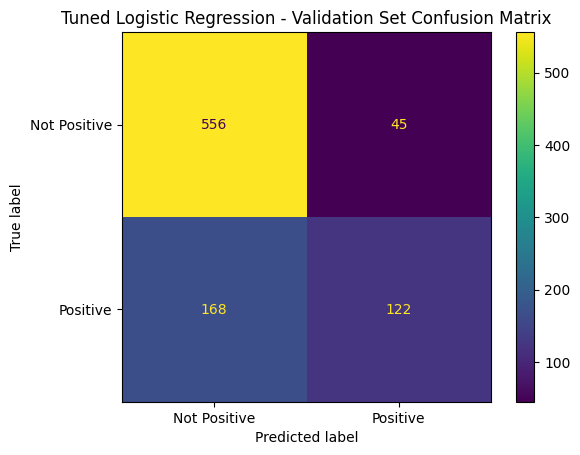

In [174]:
cm_val = confusion_matrix(y_val, y_val_pred_lr)
ConfusionMatrixDisplay(cm_val, display_labels=['Not Positive', 'Positive']).plot()
plt.title("Tuned Logistic Regression - Validation Set Confusion Matrix")
plt.show()

In [175]:
#let's mess with the preprocessing more because I feel we maxed out the classifier selection and model tuning for this current poreprocessing
